### Load Packages


In [3]:
from IPython import get_ipython
get_ipython().magic('reset -sf') 
# show images inline
%matplotlib inline
  
# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2
#!pip install haystack
# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np

from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

# set tf backend to allow memory to grow, instead of claiming everything
import tensorflow as tf
import pickle
from keras.models import model_from_json
import pandas as pd

import os
import face_recognition

import imageio
import sys
from numba import vectorize
import cv2
import haystack    
from collections import Counter
import pandas as pd
import seaborn as sns
from collections import Counter
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import multilayer_perceptron
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
sns.set(style='white', context='notebook', palette='deep')

from keras.utils import np_utils
from sklearn.model_selection import train_test_split

import time
import progressbar
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3083305462438956339, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 115920076
 locality {
   bus_id: 1
 }
 incarnation: 13192270020825111492
 physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1", name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 9456844
 locality {
   bus_id: 1
 }
 incarnation: 11920236874766367185
 physical_device_desc: "device: 1, name: GeForce GTX 1060 6GB, pci bus id: 0000:02:00.0, compute capability: 6.1"]

## RetinaNet

### Prime Session + RetinaNet

In [4]:
def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)
# set the modified tf session as backend in keras
keras.backend.tensorflow_backend.set_session(get_session())
# adjust this to point to your downloaded/trained model
# models can be downloaded here: https://github.com/fizyr/keras-retinanet/releases
model_path = 'resnet50_coco_best_v2.0.3.h5'
# load retinanet model
model = models.load_model('models/resnet50_coco_best_v2.0.3.h5', backbone_name='resnet50')
# if the model is not converted to an inference model, use the line below
# see: https://github.com/fizyr/keras-retinanet#converting-a-training-model-to-inference-model
# load label to names mapping for visualization purposes
labels_to_names = {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microwave', 69: 'oven', 70: 'toaster', 71: 'sink', 72: 'refrigerator', 73: 'book', 74: 'clock', 75: 'vase', 76: 'scissors', 77: 'teddy bear', 78: 'hair drier', 79: 'toothbrush'}
#print(model.summary())
#model.layers_by_depth

C:\Users\jdine\Documents\Anaconda3\envs\tensorflowlatest\lib\site-packages\keras\models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


### This example shows all captions and bounding boxes.

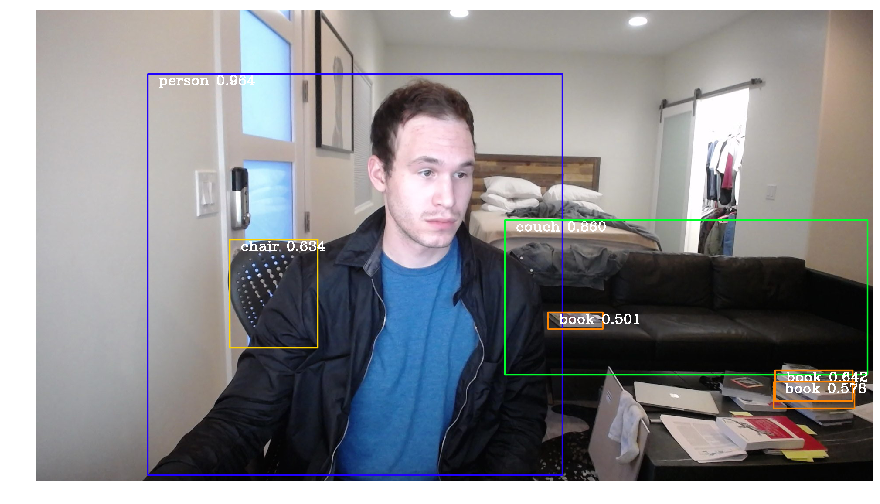

In [5]:
# Initialize vars + prime secondary model.
features = []
labs = []
scor = []
feature_extraction = [] 
layer_name = 'classification'
intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

# load image
image = read_image_bgr('sample/Jake (4).jpg')
# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
# preprocess image for network
image = preprocess_image(image)
image, scale = resize_image(image)
# process image
#start = time.time()
boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
#print("processing time: ", time.time() - start)
# correct for image scale
boxes /= scale
classes = []
# visualize detections
for box, score, label in zip(boxes[0], scores[0], labels[0]):
    # scores are sorted so we can break
    if score < 0.5:
        break        
    color = label_color(label)    
    b = box.astype(int)
    draw_box(draw, b, color=color)
    caption = "{} {:.3f}".format(labels_to_names[label], score)
    draw_caption(draw, b, caption)
    classes.append(labels_to_names[label])
    scor.append(score)
    labs.append(labels_to_names[label])
    features.append(box)
try:
    if 'person' in labs:
        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.imshow(draw)
        plt.show()
        value_index = labs.index('person')
        feature_extraction.append(intermediate_layer_model.predict(np.expand_dims(image, axis=0))[0][value_index])
except:
    if 'person' not in labs:
        print("No person in picture")


### This is for only captions/bounds of only class == 'person'. Latest Working Version
It currently only grabs a single persons array even if multiple persons present within a picture. 
Still iffy when picture contains more than one person. Not sure of which array corresponds to which bounding box.
Might need to train exclusively on single person images to avoid this. 
- Think about maybe just bounding and cropping the existing images + resaving the cropped versions.
- This would allow for data augmentation before modeling. 

- https://keras.io/getting-started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer
- https://medium.com/@14prakash/transfer-learning-using-keras-d804b2e04ef8

#### Testing Data Augmentation

In [83]:
#!pip install Augmentor
import Augmentor
p = Augmentor.Pipeline("images/","data_augmentation/")
p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
p.zoom(probability=0.5, min_factor=1.1, max_factor=1.5)
p.sample(250)


Initialised with 86 image(s) found.
Output directory set to images/data_augmentation/.

Processing <PIL.Image.Image image mode=RGB size=1920x1080 at 0x22D7B321780>: 100%|██████████| 250/250 [00:10<00:00, 23.27 Samples/s]                  


#### Feature Extraction + Image Bounding

 12% (1 of 8) |###                       | Elapsed Time: 0:00:00 ETA:   0:00:00

Processing Image:|dog.jpg| 1/8
Processing Image:|dog.jpg| 1/8


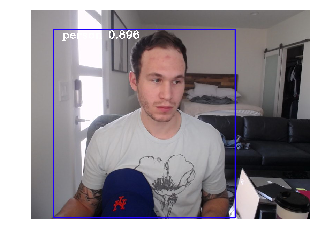

 25% (2 of 8) |######                    | Elapsed Time: 0:00:00 ETA:   0:00:02

Processing Image:|Jake (1).jpg| 2/8


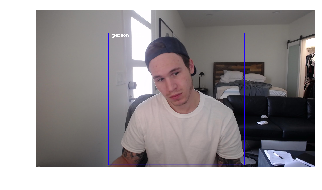

 37% (3 of 8) |#########                 | Elapsed Time: 0:00:01 ETA:   0:00:01

Processing Image:|Jake (15).jpg| 3/8


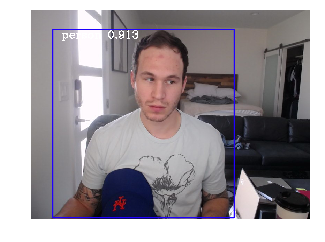

 50% (4 of 8) |#############             | Elapsed Time: 0:00:01 ETA:   0:00:01

Processing Image:|Jake (2).jpg| 4/8


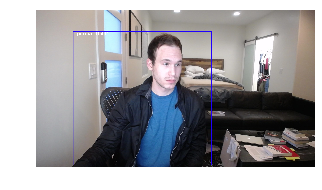

 62% (5 of 8) |################          | Elapsed Time: 0:00:02 ETA:   0:00:01

Processing Image:|Jake (4).jpg| 5/8


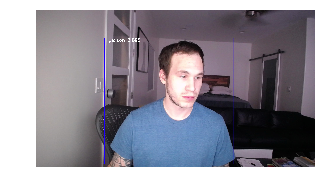

 75% (6 of 8) |###################       | Elapsed Time: 0:00:02 ETA:   0:00:00

Processing Image:|Jake (5).jpg| 6/8


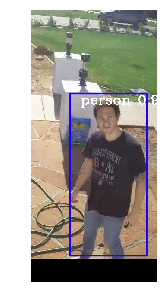

 87% (7 of 8) |######################    | Elapsed Time: 0:00:02 ETA:   0:00:00

Processing Image:|Jake.png| 7/8


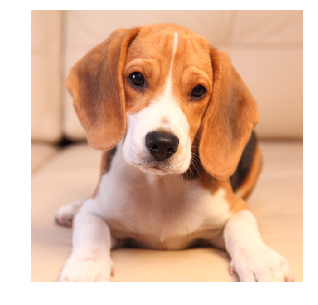

processing time: 3.02 seconds
Avg. time per pic: 0.38 seconds
Pictures processed: 8
Images not Processed: 0 []
Arrays of features extracted: 6
People found within the pictures: 6
Bounding Boxes: 6


In [20]:
# Initialize vars + prime secondary model.
labs = []
feature_extraction = []
classes = []
bounds= []
images_not_processed = []
counter = 0

#Defining feature extractor
layer_name = 'classification'
intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

#Specifying directory. 
dir = 'sample/'
allfiles = [f for f in os.listdir(dir) if os.path.splitext(f)[-1] == '.jpg' or '.png']
paths_to_images = [dir + x for x in allfiles] 
len_list = len(paths_to_images)

#True if you want output/drawn image saved and logs on.
save_files = False
Verbose = True
Logs = True #Final Performance Logs

start = time.time()
for i,l in zip(paths_to_images, progressbar.progressbar(range(0,len_list))):
    '''Loops through list as well as range of list for progress bar. 
       Progress bar only shows at the top when Verbose is off and plots are note shown
    '''
    try:
        # load image
        imgcounter = allfiles[counter]
        image = read_image_bgr(i)
        draw = image.copy() # copy to draw on
        draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
        image = preprocess_image(image) # preprocess image for network
        image, scale = resize_image(image)
        boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0)) # process image
        boxes /= scale # correct for image scale
        if Verbose == True:
            print("Processing Image:|{}| {}/{}".format(imgcounter, counter+1, len(paths_to_images)))  
    except:
        break

    if 0 in labels:
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            # scores are sorted so we can break
            if score < 0.75:
                break
            if label == 0:
                pc = Counter(label.flatten())[0]
                labs.append(labels_to_names[label])
                bounds.append(box)
                color = label_color(label)
                b = box.astype(int) 
                draw_box(draw, b, color=color) 
                caption = "{} {:.3f}".format(labels_to_names[label], score)
                draw_caption(draw, b, caption)
                if pc != 0:
                    feature_ext = (intermediate_layer_model.predict(np.expand_dims(image, axis=0))[0][0])
                    feature_extraction.append(feature_ext)
            elif label == 16:
                '''Refusing to model pics of dogs'''
                images_not_processed.append(i)
             
        try:
            if Verbose == True:
                if 'person' in labs:
                    if save_files == True:
                        '''If save_files = True, this will send the drawn-on image to the specified dir'''
                        name = ('Testing_SMS/' + str(allfiles[counter])) #Specify savepath for plots.
                        plt.figure(figsize=(5, 5))
                        plt.axis('off')
                        plt.imshow(draw)
                        plt.savefig(name) #Save image w/ bounding box
                        plt.show()
                        counter +=1

                    elif save_files == False:
                        plt.figure(figsize=(5, 5))
                        plt.axis('off')
                        plt.imshow(draw)
                        plt.show()
                        counter +=1
            if Verbose == False:
                counter +=1
                
        except:
            if 'person' not in labs:
                counter +=1
                break

                
timetaken = np.round(time.time() - start,2)
if Logs == True:                
    print("processing time: {} seconds". format(np.round(time.time() - start,2)))
    print("Avg. time per pic: {} seconds". format(np.round(timetaken/len(paths_to_images),2)))
    print("Pictures processed:", len(paths_to_images))
    print("Images not Processed: {} {}".format(len(images_not_processed), images_not_processed))
    print( "Arrays of features extracted: {}".format(len(feature_extraction)))   
    print("People found within the pictures: {}".format(len(labs)))
    print("Bounding Boxes: {}".format(len(bounds)))




#### Cropping via bounded boxes

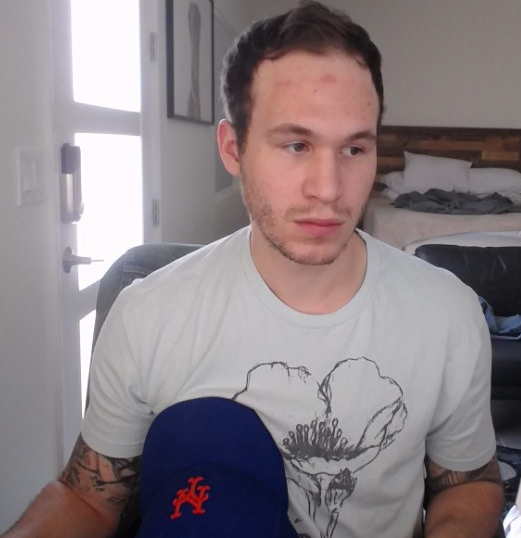

In [27]:
from PIL import Image
dir = 'sample/'
allfiles = [f for f in os.listdir(dir) if os.path.splitext(f)[-1] == '.jpg' or '.png']
paths_to_images = [dir + x for x in allfiles] #location = directory
boundss = np.array(bounds)
boundss = boundss.astype(int)
original = Image.open(paths_to_images[1])
original.crop((boundss[0][0], boundss[0][1], boundss[0][2], boundss[0][3]))




## Trying Convnet on Features Extracted

Turned this into a 2class problem trying to find the function approximation between input and class: IsJake vs IsnotJake

In [87]:
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
dir = dir
allfiles = [f for f in os.listdir(dir) if os.path.splitext(f)[-1] == '.jpg' or '.png']
paths_to_images = [dir + x for x in allfiles] #location = directory
test = []
for i in paths_to_images:
    if 'NotJake' in i:
        test.append(0)
    else:
        test.append(1)

y = np_utils.to_categorical(test,2)
x= feature_extraction
x /= np.max(x)

#Set Test Size to 0.4 after realizing initial success at a .2 threshold.
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.2, random_state=42)
xtrain = np.array(xtrain)
xtest = np.array(xtest)
ytrain = np.array(ytrain)
ytest = np.array(ytest)

lenxt = len(xtrain)
lenxts = len(xtest)

xtrain = xtrain.reshape(lenxt,20,4,1)
xtest = xtest.reshape(lenxts,20,4,1)
input_shape = xtrain.shape[1:]




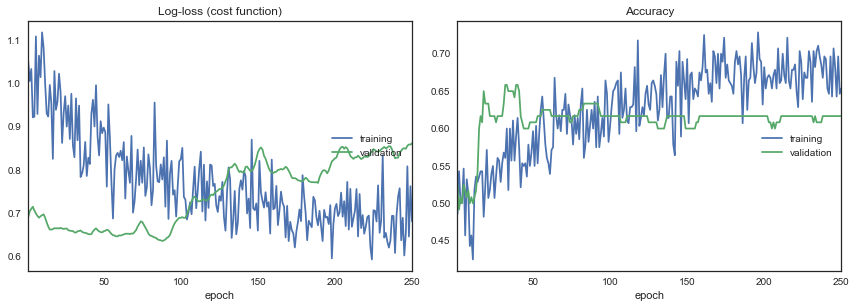

processing time: 75.82 seconds


In [91]:
############################################BUILD THE MODEL######################################################################
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
from keras.layers.advanced_activations import LeakyReLU 
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from livelossplot import PlotLossesKeras

num_classes = 2
model = Sequential()
model.add(Conv2D(1000, (1, 1), activation='relu', input_shape=input_shape, padding="same"))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(Conv2D(1000, (1, 1)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(1,1)))

model.add(Conv2D(1000, (1, 1)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(1,1)))

model.add(Conv2D(500, (1, 1)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(1,1)))

model.add(Conv2D(250, (1, 1)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(1,1)))
model.add(Dropout(0.5))

model.add(Conv2D(125,(1, 1)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(Conv2D(64, (1, 1)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(1,1)))
model.add(Dropout(0.5))
model.add(Conv2D(32, (1, 1)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(1,1)))
model.add(Dropout(0.5))
model.add(Conv2D(32, (1, 1)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(1,1)))
model.add(Dropout(0.5))
model.add(Flatten())
# Fully connected layer
model.add(Dense(512))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(512))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(64))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('sigmoid'))
#Model parameters. 
NB_EPOCH = 250
#NB_EPOCH = 50
BATCH_SIZE = 50
VERBOSE = 1 #This sets Verbose to true meaning that logging output will be displayed on screen. Verbose = 0 is default and does allow model to run faster.
NB_CLASSES = num_classes
OPTIMIZER = Adam(lr= .0001)
VALIDATION_SPLIT = .3
Loss = 'binary_crossentropy'

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5000, verbose=1, mode='auto')


    
with tf.device('/gpu:0'):
    start = time.time()
    model.compile(loss = Loss, optimizer= OPTIMIZER, metrics=['accuracy'])
    sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True))
    history = model.fit(xtrain, ytrain, batch_size= BATCH_SIZE, epochs=NB_EPOCH, verbose=VERBOSE,\
                            validation_split= VALIDATION_SPLIT, callbacks=[PlotLossesKeras(), early_stopping])
    print("processing time: {} seconds". format(np.round(time.time() - start,2)))
    endtime = time.time()


In [92]:
pred = model.predict(xtest)
pred = np.argmax(pred, axis = 1)
real = np.argmax(ytest, axis =1)
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
accuracy_score(real, pred)
print(classification_report(real,pred))

C:\Users\jdine\Documents\Anaconda3\envs\tensorflowlatest\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.58      1.00      0.73        29
          1       0.00      0.00      0.00        21

avg / total       0.34      0.58      0.43        50



## Trying Ensembling

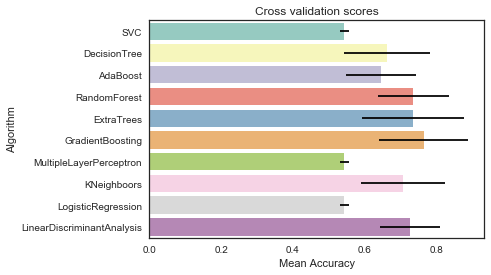

In [99]:

y = test

x= feature_extraction

#Set Test Size to 0.4 after realizing initial success at a .2 threshold.
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.3, random_state=42)
xtrain = np.array(xtrain)
xtest = np.array(xtest)
ytrain = np.array(ytrain)
ytest = np.array(ytest)


# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

# Modeling step Test differents algorithms 
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, xtrain, y = ytrain, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [100]:
X_train = xtrain
Y_train = ytrain

# Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)
gsadaDTC.fit(X_train,Y_train)
ada_best = gsadaDTC.best_estimator_

#ExtraTrees 
ExtC = ExtraTreesClassifier()
## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)
gsExtC.fit(X_train,Y_train)
ExtC_best = gsExtC.best_estimator_


# RFC Parameters tunning 
RFC = RandomForestClassifier()
## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],              
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)
gsRFC.fit(X_train,Y_train)
RFC_best = gsRFC.best_estimator_



# Gradient boosting tunning
GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)
gsGBC.fit(X_train,Y_train)
GBC_best = gsGBC.best_estimator_



### SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)
gsSVMC.fit(X_train,Y_train)
SVMC_best = gsSVMC.best_estimator_

#KNN Classifier
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn_param_grid = {'n_neighbors': [1,2,3,4,5,6,7],
                  'weights': ['uniform', 'distance'],
                  'algorithm': ['ball_tree','kd_tree', 'brute', 'auto'],
                  'leaf_size': [30,50],
                  'p': [1,2],                
                 }

gsKNN = GridSearchCV(knn,param_grid = knn_param_grid, cv=kfold, scoring="accuracy", n_jobs= 6, verbose = 1)
gsKNN.fit(X_train,Y_train)
knn_best = gsKNN.best_estimator_


#Sklearn MLP
mlp = MLPClassifier()

ml_param_grid = {
    'hidden_layer_sizes': [(100,),(500,), (1000,)],    
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': [.0001,.001,.01,.1],
    'learning_rate':  ['constant', 'invscaling', 'adaptive']}

gsMLP = GridSearchCV(mlp, param_grid=ml_param_grid, cv=kfold, scoring="accuracy", n_jobs=6, verbose=1)
gsMLP.fit(X_train,Y_train)
mlp_best = gsMLP.best_estimator_


#Sklearn Linear Disciminant 
LDA = LinearDiscriminantAnalysis()
LDA_param_grid = {
    'solver' : ['svd', 'lsqr', 'eigen']}

gsLDA = GridSearchCV(LDA, param_grid=LDA_param_grid, cv=kfold, scoring="accuracy", n_jobs=6, verbose=1)
gsLDA.fit(X_train,Y_train)
LDA_best = gsLDA.best_estimator_

#Sklearn Logit Regression
LR = LogisticRegression()
LR_param_grid = {
    'penalty' : ['l1', 'l2']}

gsLR = GridSearchCV(LR, param_grid=LR_param_grid, cv=kfold, scoring="accuracy", n_jobs=4, verbose=1)
gsLR.fit(X_train,Y_train)
LR_best = gsLR.best_estimator_






Fitting 10 folds for each of 112 candidates, totalling 1120 fits


[Parallel(n_jobs=4)]: Done 1120 out of 1120 | elapsed:    2.1s finished


Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:    7.9s finished


Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:   10.6s finished


Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Done 160 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed:    6.2s finished


Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=4)]: Done 280 out of 280 | elapsed:    1.6s finished


Fitting 10 folds for each of 224 candidates, totalling 2240 fits


[Parallel(n_jobs=6)]: Done  43 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done 2240 out of 2240 | elapsed:    2.2s finished


Fitting 10 folds for each of 432 candidates, totalling 4320 fits


[Parallel(n_jobs=6)]: Done  42 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done 1076 tasks      | elapsed:   21.5s
[Parallel(n_jobs=6)]: Done 2665 tasks      | elapsed:   44.5s
[Parallel(n_jobs=6)]: Done 4320 out of 4320 | elapsed:  1.3min finished


Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    1.0s finished


Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.7s finished


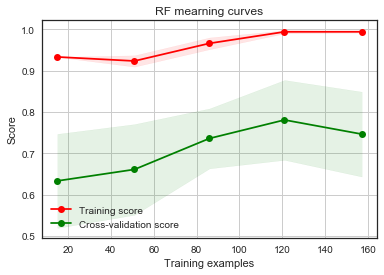

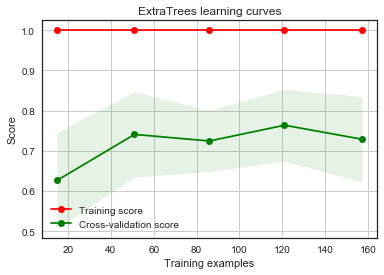

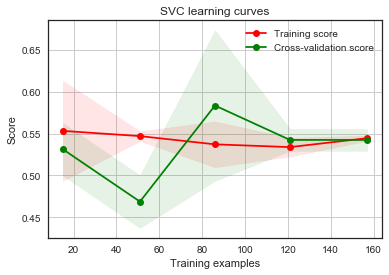

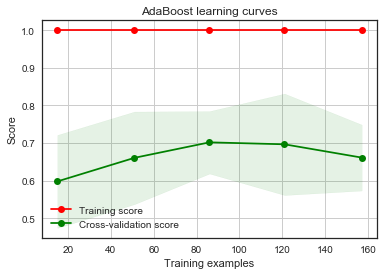

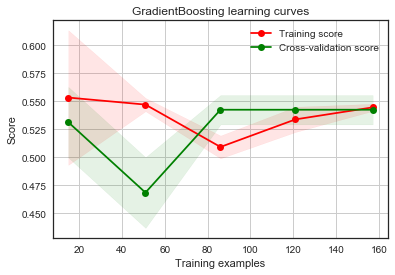

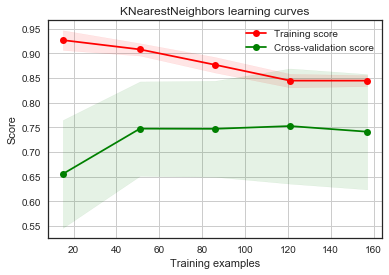

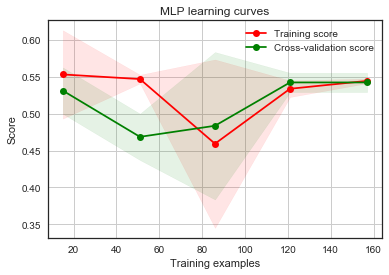

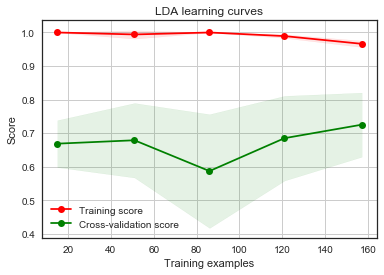

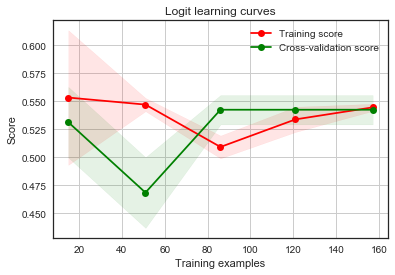

In [101]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsKNN.best_estimator_,"KNearestNeighbors learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsMLP.best_estimator_,"MLP learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsLDA.best_estimator_,"LDA learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsLR.best_estimator_,"Logit learning curves",X_train,Y_train,cv=kfold)

In [102]:
gsRFC_best = gsRFC.best_score_
gsExtC_best = gsExtC.best_score_
gsSVMC_best = gsSVMC.best_score_
gsadaDTC_best = gsadaDTC.best_score_
gsGBC_best = gsGBC.best_score_
gsKNN_best = gsKNN.best_score_
gsMLP_best = gsMLP.best_score_
gsLDA_best = gsLDA.best_score_
gsLR_best = gsLR.best_score_

scores = [gsRFC_best, gsExtC_best, gsSVMC_best, gsadaDTC_best, gsGBC_best, gsKNN_best, gsMLP_best,\
         gsLDA_best, gsLR_best]

scores_strings = ['gsRFC_best', 'gsExtC_best', 'gsSVMC_best', 'gsadaDTC_best', 'gsGBC_best', 'gsKNN_best', \
                  'gsMLP_best', 'gsLDA_best', 'gsLR_best']


for scorestrings, score in zip(scores_strings, scores):
    print (scorestrings + ':', np.round(score,2)*100)

gsRFC_best: 77.0
gsExtC_best: 77.0
gsSVMC_best: 54.0
gsadaDTC_best: 74.0
gsGBC_best: 54.0
gsKNN_best: 74.0
gsMLP_best: 54.0
gsLDA_best: 73.0
gsLR_best: 54.0


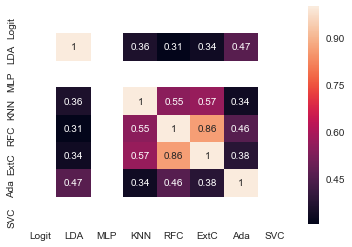

In [103]:
test_RFC = pd.Series(RFC_best.predict(xtest), name="RFC")
test_ExtC = pd.Series(ExtC_best.predict(xtest), name="ExtC")
test_SVMC = pd.Series(SVMC_best.predict(xtest), name="SVC")
test_AdaC = pd.Series(ada_best.predict(xtest), name="Ada")
test_GBC = pd.Series(GBC_best.predict(xtest), name="GBC")
test_KNN = pd.Series(knn_best.predict(xtest), name="KNN")
test_MLP = pd.Series(mlp_best.predict(xtest), name="MLP")
test_LDA = pd.Series(LDA_best.predict(xtest), name="LDA")
test_LR = pd.Series(LR_best.predict(xtest), name="Logit")



# Concatenate all classifier results
ensemble_results = pd.concat([test_LR, test_LDA, \
test_MLP,test_KNN, test_RFC,test_ExtC,test_AdaC, \
                              test_SVMC],axis=1)


g= sns.heatmap(ensemble_results.corr(),annot=True)

In [104]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),
('svc', SVMC_best), ('adac',ada_best),
 ('knn',knn_best), ('mlp', mlp_best), ('lda', LDA_best), ('lr', LR_best)],voting='soft', n_jobs=10)

votingC = votingC.fit(X_train, Y_train)
y_pred = pd.Series(votingC.predict(xtest), name="Class")
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

print(accuracy_score(ytest,y_pred))
print(classification_report(ytest, y_pred))

C:\Users\jdine\Documents\Anaconda3\envs\tensorflowlatest\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.8
             precision    recall  f1-score   support

          0       0.89      0.80      0.84        50
          1       0.67      0.80      0.73        25

avg / total       0.81      0.80      0.80        75

